**Progetto Simone Giorgio, matricola 214575**

In [ ]:
SEED = 9246

import os
import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models

from PIL import Image

from skimage import io
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from torch.nn.modules.utils import _triple
import math

import torchsummary

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/'

/content/drive/My Drive


In [ ]:
DATASET_DIR = 'ComputerVision/progetto_2021_dataset'
DRIVE_FOLDER = 'ComputerVision/model_checkpoint'

JSON_DATA_OLD = 'ComputerVision/progetto_2021_dataset/train_test_split_dict.json'

with open(JSON_DATA_OLD) as fp:
    dataset_json = json.load(fp)

print(len(dataset_json["train"]))

4292


In [ ]:
DATASET_DIR = 'ComputerVision/progetto_2021_dataset'
DRIVE_FOLDER = 'ComputerVision/model_checkpoint'

JSON_DATA = 'ComputerVision/train_test_split_dict_UNDERSAMPLING1.json'

with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)

print(len(dataset_json["train"]))

3914


In [ ]:
labels = set()

for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)

label_idx = {v: i for i, v in enumerate(sorted(labels))}

print(len(label_idx))

85


**Data Analysis**

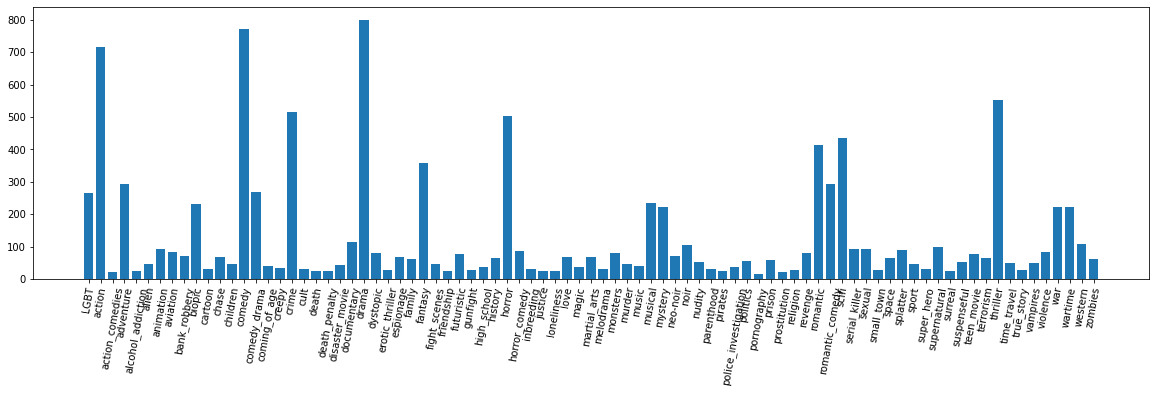

In [ ]:
files=np.array(list(dataset_json['train'].keys()))
diz=dataset_json['train']
totale=torch.zeros(len(label_idx), dtype=torch.float32)
for name in files:
  labels = torch.zeros(len(label_idx), dtype=torch.float32)
  for label in diz[name]:
    labels[label_idx[label]] = 1
  totale+=labels

etichette=np.array(list(label_idx.keys()))

plt.figure(figsize=(20,5))
plt.bar(etichette,totale)
plt.xticks(rotation=80)
plt.show()

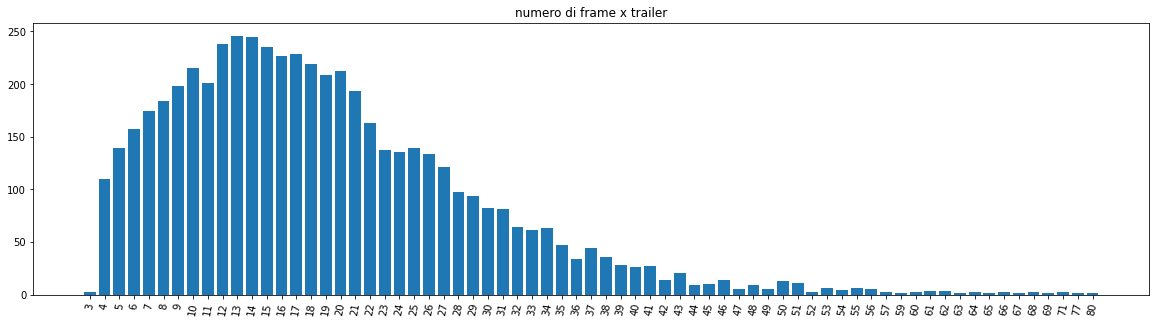

In [ ]:
files = os.listdir(DATASET_DIR)

dic = {}
for f in files:
    if '.json' not in f:
        leng = len(os.listdir(os.path.join(DATASET_DIR,f)))
        if leng not in dic:
            dic[leng]=0
        dic[leng] +=1


dic = dict(sorted(dic.items(), key=lambda item: item[0]))
numeroFrame = [*map(str,dic.keys())]
occorrenze = list(dic.values())

plt.figure(figsize=(20,5))
plt.title("numero di frame x trailer")
plt.bar(numeroFrame,occorrenze)
plt.xticks(rotation=80)
plt.show()

**Load Data**

In [ ]:
class VideoDataset(Dataset):

    def __init__(self, dataset_folder, labels_dict, transform=None, limit=15):
        """
        Args:
            dataset_folder (string): Path to the folder with mp4 files.
            labels_dict (dict): dict filename - list of label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self.limit = limit
        self.transform = transform or torchvision.transforms.ToTensor()

        self._files = np.array(list(self.labels_dict.keys()))

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, idx):
        name = self._files[idx]   #nome cartella trailer

        x = torch.zeros(self.limit, 3, 224, 224)
        folder_pattern = os.path.join(self.root_dir, name, '*.png')
        images = io.imread_collection(folder_pattern)

        for i, image in enumerate(images):
            if i < self.limit:
                image = self.transform(Image.fromarray(image))
                x[i] = image.unsqueeze(0)

        #calcolo etichette per trailer
        labels = torch.zeros(len(label_idx), dtype=torch.float32)
        for label in self.labels_dict[name]:
            labels[label_idx[label]] = 1

        return x, labels

In [ ]:
transformations = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

datasetTrain = VideoDataset(DATASET_DIR, dataset_json['train'], transformations)
datasetTest = VideoDataset(DATASET_DIR, dataset_json['test'], transformations)

print(len(datasetTrain))
print(len(datasetTest))

3914
1112


In [ ]:
batch_size = 16
trainingDataLoader = torch.utils.data.DataLoader(datasetTrain,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=2,
                                                 drop_last=True)
testDataLoader = torch.utils.data.DataLoader(datasetTest,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             num_workers=2)

**Model**

In [ ]:
import torchvision.models as models

vgg = models.vgg19(pretrained = True)

for params in vgg.parameters():
  params.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import torch.nn.functional as F

class SimoNet(nn.Module):
  def __init__(self):
    super(SimoNet, self).__init__()
    self.featureVgg=vgg.features

    self.classifier= nn.Sequential(
        nn.Linear(25088 , 6656),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(6656 , 1024),
        nn.ReLU(True),
        nn.Linear(1024 , 1024),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(1024 , 85),
        nn.Sigmoid()
    )

  def forward(self,x):  #x= batch, frames, c, h, w
    batch= torch.zeros((16,512*7*7))  #batch, frame, dim_feature_map

    i=0
    for film in x:
      output= self.featureVgg(film) # output ([15, 512, 7, 7])
      output=output.reshape(15,512*7*7)
      output=torch.mean(output, dim=0)
      batch[i]=output
      i+=1
    result=self.classifier(batch.to(device))
    return result

In [ ]:
model=SimoNet()
model=model.to(device)

optimizer= optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
print(model)

SimoNet(
  (featureVgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
criterion=nn.BCELoss()

In [ ]:
CHECKPOINT = os.path.join(DRIVE_FOLDER, 'modelVGG19.checkpoint')
MODELFILE = os.path.join(DRIVE_FOLDER, 'modelVGG19.pth')

def save_checkpoint(epoch, model, optimizer, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT)

def load_checkpoint(model, optimizer):
    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

def save_model(model):
    torch.save(model.state_dict(), MODELFILE)

def load_model(model):
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))

**Train**

In [ ]:
epoca=0

epoca, error = load_checkpoint(model,optimizer)

epochs = 1
train_losses = []
last_epoch = epoca
print_every = 5

try:
    for epoch in range(last_epoch or 0, epochs):
        print('Start epoch', epoch+1)
        model.train()
        running_loss = 0
        steps = 0

        for x, y in trainingDataLoader:
            steps += 1

            if epoch == 0 and steps == 1:
                print(f'input shape is {x.shape}, labels are {y.shape}')


            x=x.view(16,15,3,224,224)                     #batch, frames, c, h, w

            optimizer.zero_grad()
            logit = model.forward(x.to(device))

            loss = criterion(logit, y.to(device))
            loss.backward()

            optimizer.step()
            running_loss += loss.item()


            if steps % print_every == 0:
                print(f"epoch {epoch+1}/{epochs} "
                      f"train loss: {running_loss/steps:.6f} Labeled")

                save_checkpoint(epoch, model, optimizer, loss)

        save_model(model)
        train_losses.append(running_loss/steps)
        print(f"END Epoch {epoch+1}/{epochs} "
              f"Train loss: {running_loss/steps:.6f} ")

except KeyboardInterrupt:
    print('Exiting from training early')

Start epoch 1
input shape is torch.Size([16, 15, 3, 224, 224]), labels are torch.Size([16, 85])
epoch 1/1 train loss: 0.120856 Labeled
epoch 1/1 train loss: 0.108598 Labeled
epoch 1/1 train loss: 0.110406 Labeled
epoch 1/1 train loss: 0.111113 Labeled
epoch 1/1 train loss: 0.112395 Labeled
epoch 1/1 train loss: 0.112059 Labeled
epoch 1/1 train loss: 0.109795 Labeled
epoch 1/1 train loss: 0.109408 Labeled
epoch 1/1 train loss: 0.109414 Labeled
epoch 1/1 train loss: 0.110490 Labeled
epoch 1/1 train loss: 0.109736 Labeled
epoch 1/1 train loss: 0.109772 Labeled
epoch 1/1 train loss: 0.109401 Labeled
epoch 1/1 train loss: 0.109062 Labeled
epoch 1/1 train loss: 0.108335 Labeled
epoch 1/1 train loss: 0.108135 Labeled
epoch 1/1 train loss: 0.107632 Labeled
epoch 1/1 train loss: 0.107631 Labeled
epoch 1/1 train loss: 0.107365 Labeled
epoch 1/1 train loss: 0.107125 Labeled
epoch 1/1 train loss: 0.107003 Labeled
epoch 1/1 train loss: 0.106905 Labeled
epoch 1/1 train loss: 0.106655 Labeled
epoch 1

**Test**

In [ ]:
topk=10
predictions = []
y_true = []

model.eval()

with torch.no_grad():
    step = 0
    for inputs, labels in testDataLoader:

        step += 1
        inputs,label = inputs.view(16,15,3,224,224), labels.to(device)
        logps = model(inputs.to(device))
        y_pred = logps

        _, idx = y_pred.topk(topk, dim=1)

        y_pred = torch.zeros_like(y_pred)
        y_pred.scatter_(1, idx, 1)
        predictions.append(y_pred.cpu())

        y_true.append(label.cpu())

y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
report = classification_report(y_true, predictions,
                               target_names=list(sorted(label_idx.keys())),zero_division=0)
print(report)

                      precision    recall  f1-score   support

                LGBT       0.08      0.80      0.14        61
              action       0.18      0.99      0.30       189
     action_comedies       0.00      0.00      0.00         6
           adventure       0.14      0.57      0.23        74
   alcohol_addiction       0.00      0.00      0.00         6
               alien       0.00      0.00      0.00        12
           animation       0.38      0.48      0.43        21
            aviation       0.00      0.00      0.00        20
        bank_robbery       0.00      0.00      0.00        19
              biopic       0.08      0.38      0.13        58
             cartoon       0.11      0.14      0.12         7
               chase       0.00      0.00      0.00        16
            children       0.00      0.00      0.00        12
              comedy       0.19      0.96      0.32       210
        comedy_drama       0.08      0.59      0.14        63
       